# Minimal Demo

This notebook will use the small test data shapefiles to build a graph and find distances.

In [1]:
# the matplotlib line is just for the notebook
# it's not required elsewhere
%matplotlib inline
import pyriv
import os # used for file paths

In [2]:
data_dir = "../tests/testdata/"
fp = lambda s: os.path.join(data_dir, s)

In [3]:
land_fn = fp('CoastLine.shp')
rivers_fn = fp('Rivers.shp')
points_fn = fp('UpriverTestPoints.shp')

## Simple Case

For this case we'll assume that all of our input data is perfect. All river dead ends are rivermouths, and the rivermouths are nodes on the coastline. First we'll work with just the rivers, and generate distances for a set of points up the rivers. 

Then, we'll generate a coastal network, join it to the river network, and calculated distances between points and a distance matrix for the full set up points.

### Build River Network

Load a river shapefile, but don't load a coast shapefile. This will assume that all dead ends are rivermouths.

In [4]:
rivnet = pyriv.RiverGraph(data=rivers_fn)

/usr/local/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/usr/local/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


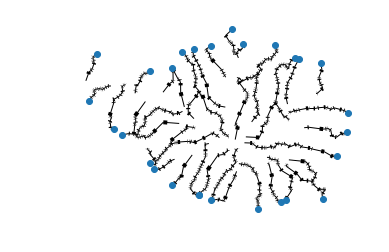

In [5]:
ax = rivnet.deadend_gdf().plot(zorder=2)
rivnet.plot(ax=ax, zorder=1)
ax.set_axis_off()